In [1]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
import copy
import numpy as np
from models.fno import FNO
from models.pfno import PFNO, PNO_Wrapper
from models.laplace import LA_Wrapper
from models.mcdropout import generate_mcd_samples
from data.datasets import DarcyFlowDataset
import cmcrameri
from matplotlib.colors import Normalize
import matplotlib as mpl
from matplotlib.colors import ListedColormap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loader for best predictions

In [2]:
batch_size = 32
n_samples = 100 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval

data_dir = "../../data/DarcyFlow/processed/"
checkpoint_path = "/home/groups/ai/scholl/pfno/weights/darcy_flow/fno/"

sr_dropout_path = checkpoint_path + "20240913_104527_darcy_flow_fno_sr_dropout/Datetime_20240913_104537_Loss_DarcyFlow_FNO_scoring-rule-dropout_dropout_0.2.pt"
laplace_path = checkpoint_path + "20240915_013209_darcy_flow_fno_laplace/Datetime_20240915_013216_Loss_DarcyFlow_FNO_laplace_dropout_0.02.pt"
dropout_path = checkpoint_path + "20240914_125831_darcy_flow_fno_dropout/Datetime_20240914_125838_Loss_DarcyFlow_FNO_dropout_dropout_0.02.pt"
sr_reparam_path = checkpoint_path + "20240915_141034_darcy_flow_fno_sr_reparam/Datetime_20240915_141041_Loss_DarcyFlow_FNO_scoring-rule-reparam_dropout_0.01.pt"

In [3]:
test_data = DarcyFlowDataset(data_dir, test = True)

# Get domain and range
x,y = test_data.get_coordinates()
L = test_data.get_domain_range()
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
n_test = len(test_loader)

In [4]:
dropout_model = FNO(n_modes=(12,12), hidden_channels=32, in_channels = 3,dropout=0.02).to(device)
dropout_cp = torch.load(dropout_path, map_location=torch.device(device))
dropout_model.load_state_dict(dropout_cp)

laplace_model = FNO(n_modes=(12,12), hidden_channels=32, in_channels = 3,dropout=0.02).to(device)
la_model = LA_Wrapper(laplace_model)

la_model.load_state_dict(laplace_path)

pfno_reparam = PFNO(n_modes=(12,12), hidden_channels=32, in_channels = 3,dropout=0.01, n_samples = n_samples).to(device)
pfno_cp = torch.load(sr_reparam_path, map_location=torch.device(device))
pfno_reparam.load_state_dict(pfno_cp)

sr_dropout_model = FNO(n_modes=(12,12), hidden_channels=32, in_channels = 3,dropout=0.2).to(device)
sr_dropout_cp = torch.load(sr_dropout_path, map_location=torch.device(device))
pfno_dropout = PNO_Wrapper(sr_dropout_model, n_samples = n_samples)
pfno_dropout.load_state_dict(sr_dropout_cp)

<All keys matched successfully>

# Predictions

In [34]:
# Generate random samples for plotting
np.random.seed(42)
torch.manual_seed(42)
samples = np.random.randint(0,n_test,5)

In [35]:
pfno_dropout.train()
dropout_model.train()
pfno_reparam.eval()
""" Prediction """
pred_pfno_dropout = []
pred_pfno_reparam = []
pred_dropout = []
pred_la = []

with torch.no_grad():    
    index = 0
    for sample in samples:
        a,u = test_data.__getitem__(sample)
        a = a.to(device).unsqueeze(0)
        u = u.to(device).unsqueeze(0)
        dropout_pred = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples)
        pfno_dropout_pred = pfno_dropout(a, n_samples = n_samples)
        pfno_reparam_pred = pfno_reparam(a)
        la_pred = la_model.predictive_samples(a)

        pred_dropout.append( dropout_pred )
        pred_pfno_dropout.append( pfno_dropout_pred )
        pred_pfno_reparam.append( pfno_reparam_pred )
        pred_la.append( la_pred )


pred_pfno_dropout = torch.cat(pred_pfno_dropout, dim = 0).cpu().numpy()
pred_pfno_reparam = torch.cat(pred_pfno_reparam, dim = 0).cpu().numpy()
pred_dropout = torch.cat(pred_dropout, dim = 0).cpu().numpy()
pred_la = torch.cat(pred_la, dim = 0).cpu().numpy()

In [36]:
def plot_statistics(truth, preds, names, grid, save_path = None, alpha = 0.05):
    n_models = len(preds)
    x,y = grid

    tick_size = 16
    title_size = 19
    mpl.rcParams['xtick.labelsize'] = tick_size
    mpl.rcParams['ytick.labelsize'] = tick_size

    # Discrete colorbar
    viridis = mpl.colormaps["viridis"]
    col_dict = {0: viridis(0),
                1: viridis(0.999)}

    # We create a colormar from our list of colors
    cmap_coverage = ListedColormap([col_dict[x] for x in col_dict.keys()])

    # Get scalings
    pred_array = np.array(preds)
    mse_norm = Normalize(vmin = 0, vmax = np.power(truth - pred_array.mean(axis = -1),2).max())
    std_norm = Normalize(vmin = 0, vmax = pred_array.std(axis = -1).max())
    

    fig, axs = plt.subplots(3,n_models, figsize = (18,12), subplot_kw=dict(box_aspect=1.0),
                         sharex=True, sharey=True, layout = "constrained")
    
    for m, pred in enumerate(preds):
        truth = truth.squeeze()
        pred = pred.squeeze()
        # Calculate coverage
        q_lower = np.quantile(pred,alpha/2, axis = -1)
        q_upper = np.quantile(pred,1-alpha/2, axis = -1)
        coverage = (truth>q_lower) & (truth<q_upper)
        im1 = axs[0,m].pcolormesh(x,y,np.power(truth - pred.mean(axis = -1),2), shading = "nearest", cmap = "cmc.vik", norm = mse_norm, rasterized = True)
        im2 = axs[1,m].pcolormesh(x,y,pred.std(axis = -1), shading = "nearest", cmap = "cmc.lipari", norm = std_norm, rasterized = True)
        im3 = axs[2,m].pcolormesh(x,y,coverage, shading = "nearest", cmap = cmap_coverage, rasterized = True)
        axs[0,m].set_title(names[m], fontsize = 24)
        print(f"{names[m]}- Coverage: {coverage.mean()}")
    cb1 = fig.colorbar(im1, ax = axs[0,m])
    cb1.ax.tick_params(labelsize=tick_size) 
    cb1.set_label('Squared error',size=title_size)
    cb2 = fig.colorbar(im2, ax = axs[1,m], label = "Standard deviation")
    cb2.ax.tick_params(labelsize=tick_size)
    cb2.set_label('Standard deviation',size=title_size)
    cb3 = fig.colorbar(im3, ax = axs[2,m], label = "", ticks = np.array([0,1]))
    cb3.ax.tick_params(labelsize=tick_size)
    cb3.set_label(r"Coverage ($\alpha = 0.05$)",size=title_size)

    # Set axis labels
    for m in range(n_models):
        axs[-1,m].set_xlabel(r"$x_1$", fontsize = tick_size)
    for m in range(3):
        axs[m,0].set_ylabel(r"$x_2$", fontsize = tick_size)
        
    #fig.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi = 300, bbox_inches = "tight")
    
    plt.show()

In [37]:
def plot_predictions(truth, preds, names, grid, save_path = None, alpha = 0.05):
    n_models = len(preds)
    x,y = grid

    tick_size = 16
    title_size = 19
    mpl.rcParams['xtick.labelsize'] = tick_size
    mpl.rcParams['ytick.labelsize'] = tick_size

    # Discrete colorbar
    viridis = mpl.colormaps["viridis"]
    col_dict = {0: viridis(0),
                1: viridis(0.99)}

    # We create a colormar from our list of colors
    cmap_coverage = ListedColormap([col_dict[x] for x in col_dict.keys()])

    # Get scalings
    pred_array = np.array(preds)
    truth_norm = Normalize(vmin = truth.min(), vmax = truth.max())
    std_norm = Normalize(vmin = 0, vmax = pred_array.std(axis = -1).max())
    

    fig, axs = plt.subplots(4,n_models, figsize = (18,16), subplot_kw=dict(box_aspect=1.0),
                         sharex=True, sharey=True, layout = "constrained")
    
    for m, pred in enumerate(preds):
        truth = truth.squeeze()
        pred = pred.squeeze()
        # Calculate coverage
        q_lower = np.quantile(pred,alpha/2, axis = -1)
        q_upper = np.quantile(pred,1-alpha/2, axis = -1)
        coverage = (truth>q_lower) & (truth<q_upper)
        im1 = axs[0,m].pcolormesh(x,y,truth, shading = "nearest", cmap = "cmc.batlow", norm = truth_norm, rasterized = True)
        im2 = axs[1,m].pcolormesh(x,y,pred.mean(axis = -1), shading = "nearest", cmap = "cmc.batlow", norm = truth_norm, rasterized = True)
        im3 = axs[2,m].pcolormesh(x,y,pred.std(axis = -1), shading = "nearest", cmap = "cmc.lipari", norm = std_norm, rasterized = True)
        im4 = axs[3,m].pcolormesh(x,y,coverage, shading = "nearest", cmap = cmap_coverage, rasterized = True)
        axs[0,m].set_title(names[m], fontsize = 24)
        print(f"{names[m]}- Coverage: {coverage.mean()}")
    cb1 = fig.colorbar(im1, ax = axs[0,m])
    cb1.ax.tick_params(labelsize=tick_size) 
    cb1.set_label('Ground truth',size=title_size)
    cb2 = fig.colorbar(im2, ax = axs[1,m], label = "Mean prediction")
    cb2.ax.tick_params(labelsize=tick_size)
    cb2.set_label('Mean prediction',size=title_size)
    cb3 = fig.colorbar(im3, ax = axs[2,m], label = "Standard deviation")
    cb3.ax.tick_params(labelsize=tick_size)
    cb3.set_label('Standard deviation',size=title_size)
    cb4 = fig.colorbar(im4, ax = axs[3,m], label = "", ticks = np.array([0,1]))
    cb4.ax.tick_params(labelsize=tick_size)
    cb4.set_label(r"Coverage ($\alpha = 0.05$)",size=title_size)

    # Set axis labels
    for m in range(n_models):
        axs[-1,m].set_xlabel(r"$x_1$", fontsize = tick_size)
    for m in range(3):
        axs[m,0].set_ylabel(r"$x_2$", fontsize = tick_size)
        
    #fig.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi = 300, bbox_inches = "tight")
    
    plt.show()

# Plot

In [38]:
idx = 2

a,u = test_data.__getitem__(samples[idx])
a = a.unsqueeze(0).numpy()
u = u.unsqueeze(0).numpy()

preds = [pred_dropout[idx], pred_la[idx], pred_pfno_dropout[idx], pred_pfno_reparam[idx]]
names = ['MCD', 'LA', r'$\mathrm{PNO_{D}}$', r'$\mathrm{PNO_{R}}$']

MCD- Coverage: 0.4256591796875
LA- Coverage: 0.99365234375
$\mathrm{PNO_{D}}$- Coverage: 0.98724365234375
$\mathrm{PNO_{R}}$- Coverage: 0.53021240234375


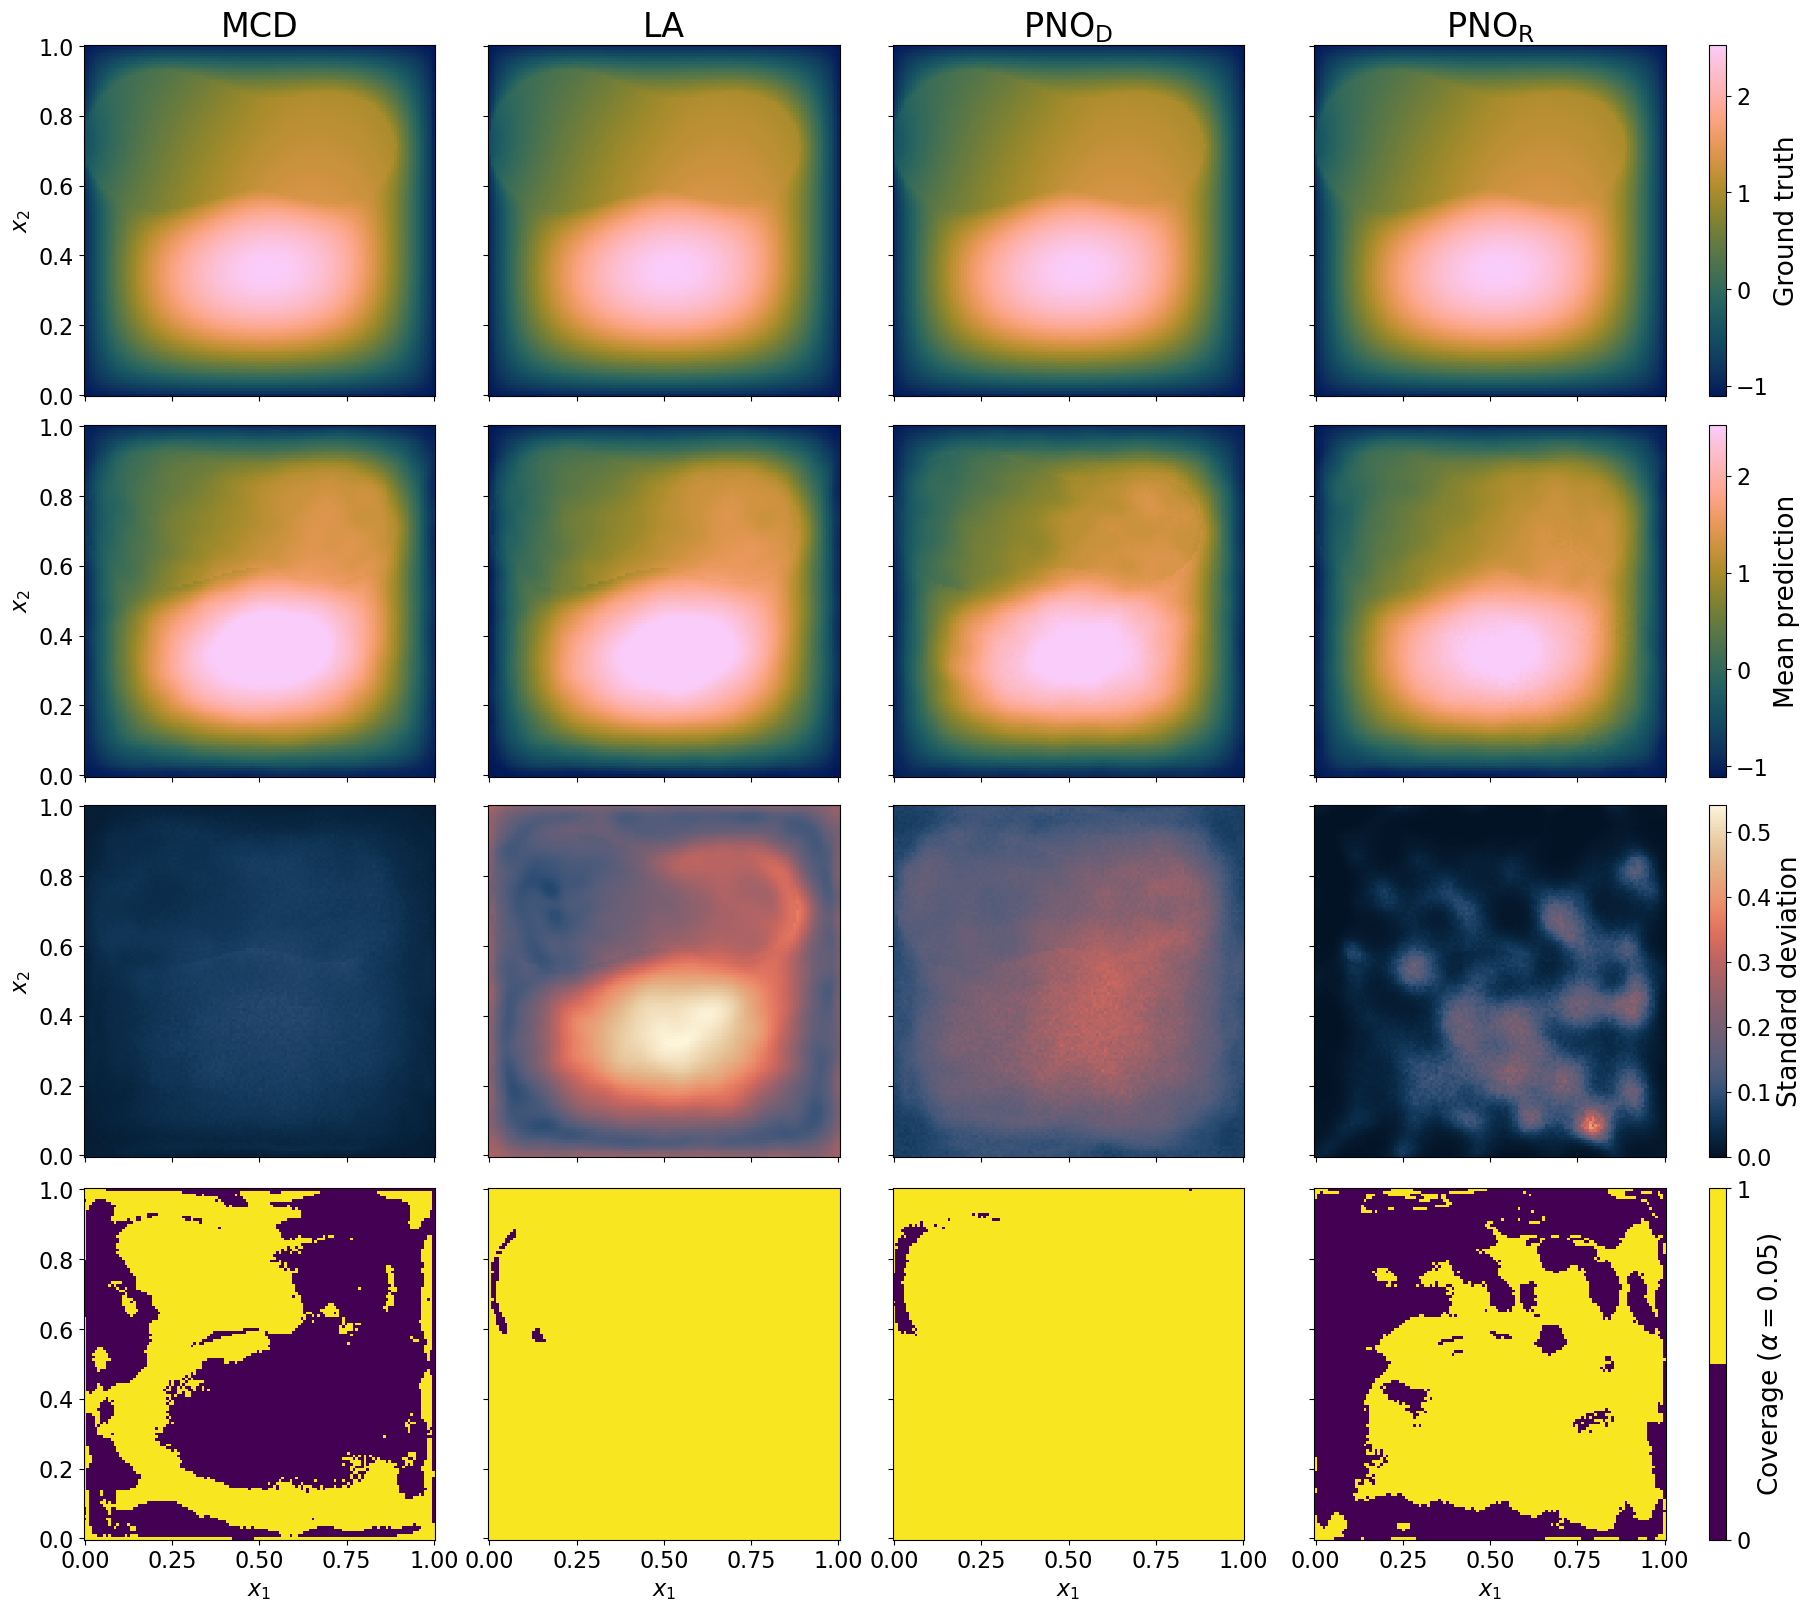

In [39]:
plot_predictions(u, preds, names, (x,y), save_path = "plots/darcy_flow_predictions.pdf")

MCD- Coverage: 0.4256591796875
LA- Coverage: 0.99365234375
$\mathrm{PNO_{D}}$- Coverage: 0.98724365234375
$\mathrm{PNO_{R}}$- Coverage: 0.53021240234375


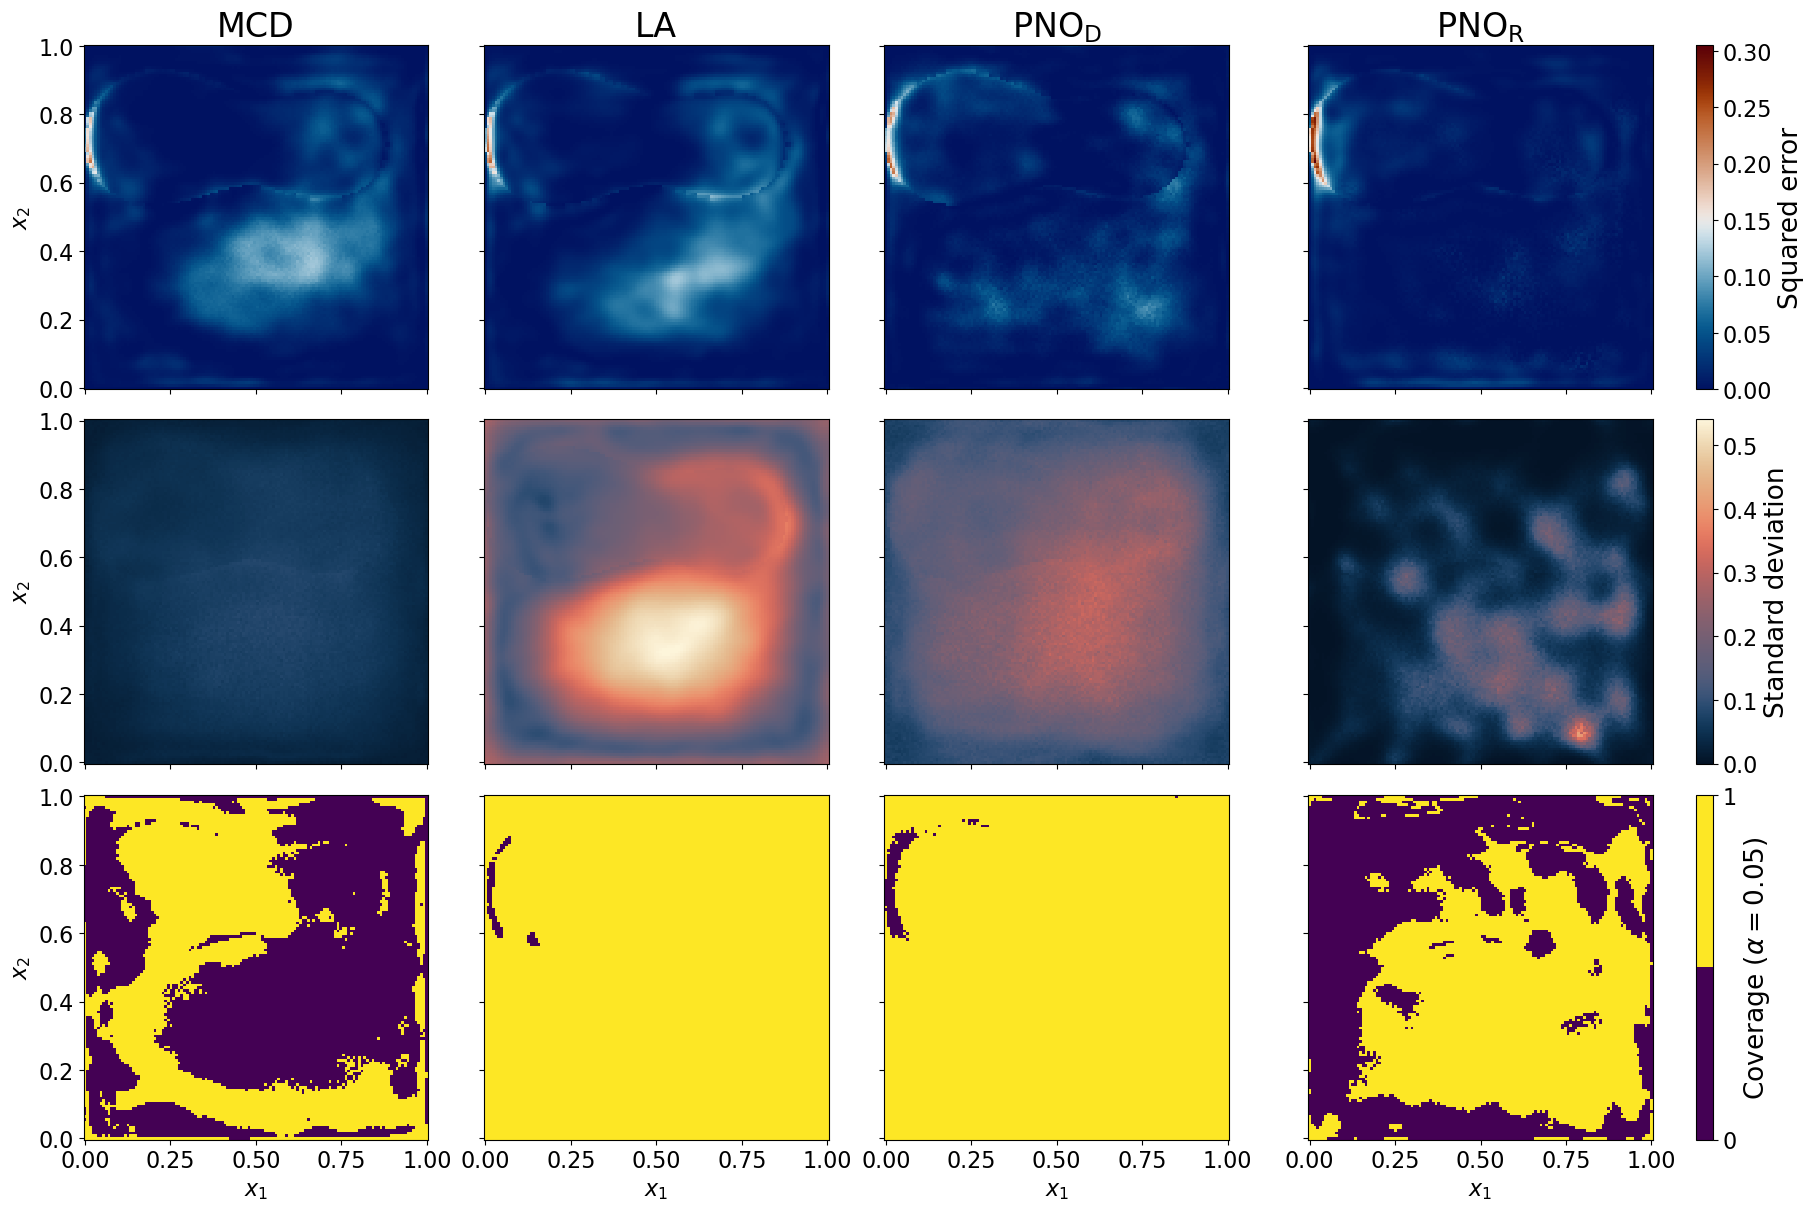

In [40]:
plot_statistics(u, preds, names, (x,y), save_path = "plots/darcy_flow_statistic.pdf")